In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from matplotlib import pyplot as plt
#Daten einlesen
input_dir = './Data/Preparation/merged_typologien.xlsx'
df = pd.read_excel(input_dir)
df.columns

Index(['Gemeinde', 'Gemeinde ID', 'Mittlere Wohnbevölkerung',
       'Ständige Wohnbevölkerung Total',
       'Ständige Wohnbevölkerung Ausländer-anteil in %',
       'Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2',
       'Ständige Wohnbevölkerung Anteil 0-19-Jährige in %',
       'Ständige Wohnbevölkerung Anteil 20-64-Jährige in %',
       'Ständige Wohnbevölkerung Anteil 65-Jährige und Ältere in %', 'Jahr',
       'Gemeindetypologien'],
      dtype='object')

In [8]:
growth = []
for gemeinde in df['Gemeinde'].unique():
    # print(gemeinde)
    gemeinde_df = df[df['Gemeinde'] == gemeinde]
    # print(gemeinde_df[['Jahr', 'Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2']])
    min_jahr = min(gemeinde_df['Jahr'])
    max_jahr = max(gemeinde_df['Jahr'])
    
    min_jahr_dichte = gemeinde_df[gemeinde_df['Jahr'] == min_jahr]['Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2'].item()
    max_jahr_dichte = gemeinde_df[gemeinde_df['Jahr'] == max_jahr]['Ständige Wohnbevölkerung Bevölkerungs-dichte1 in Pers./km2'].item()
      
    delta = max_jahr_dichte - min_jahr_dichte
    growth.append(delta / min_jahr_dichte)
    
# print(growth)
    
    
df_cedric = pd.DataFrame({'Gemeinde': df['Gemeinde'].unique(), 'Growth': growth})
df_cedric


,Gemeinde,Growth
0,Kanton Luzern,0.287872
1,Adligenswil,0.249358
2,Aesch,0.440204
3,Alberswil,0.541701
4,Altbüron,0.390991
...,...,...
76,Werthenstein,0.102751
77,Wikon,0.079928
78,Willisau,0.169014
79,Wolhusen,0.149294


In [9]:
print(df_cedric[df_cedric.Growth == df_cedric.Growth.min()])
print(df_cedric[df_cedric.Growth == df_cedric.Growth.max()])

   Gemeinde    Growth
58   Romoos -0.189573
     Gemeinde    Growth
51  Oberkirch  1.153882


In [10]:


scaler = MinMaxScaler()

df_cedric["percentage_normalized"] = scaler.fit_transform(df_cedric[['Growth']])

In [12]:
municipalities_shapedata = gpd.read_file("./ced/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp")
municipalities_shapedata = municipalities_shapedata.drop(set(municipalities_shapedata.columns) ^ \
 {'NAME', 'BFS_NUMMER', 'KANTONSNUM', 'GEM_FLAECH', 'BEZIRKSNUM', 'geometry'}, axis=1).reset_index(drop=True)

In [13]:
Kantonsnummer=municipalities_shapedata[municipalities_shapedata.NAME.str.contains("Luzern")].KANTONSNUM.values[0]
lu_municipalities_shapedata = municipalities_shapedata[municipalities_shapedata.KANTONSNUM == Kantonsnummer].reset_index(drop=True)

In [14]:
# remove (LU) from name
lu_municipalities_shapedata['NAME'] = lu_municipalities_shapedata['NAME'].str.replace(r' \(LU\)', '', regex=True)
lu_municipalities_shapedata['NAME'] = lu_municipalities_shapedata['NAME'].str.replace(' bei Willisau', '', regex=False)
lu_municipalities_shapedata.count()

BEZIRKSNUM    85
NAME          85
KANTONSNUM    85
BFS_NUMMER    85
GEM_FLAECH    80
geometry      85
dtype: int64

In [15]:
lu_municipalities_shapedata = lu_municipalities_shapedata.merge(df_cedric, left_on='NAME', right_on='Gemeinde', how='left')

In [30]:
def plot_on_lucerne_map(prepared_gdf_data, title, f_size=(15,15)):
  fig = plt.figure(figsize=f_size)
  ax = fig.add_subplot(1,1,1)
  ax = prepared_gdf_data.plot('percentage_normalized', cmap='Wistia', legend=True, ax=ax, edgecolor='gray')
  #ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
  ax.set_title(title)

  # Remove spines
  for spine in ['top', 'bottom', 'left', 'right']:
      ax.spines[spine].set_visible(False)

  # Remove x, y ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

  # set visibility of x-axis as False
  xax = ax.axes.get_xaxis()
  xax = xax.set_visible(False)
  
  # set visibility of y-axis as False
  yax = ax.axes.get_yaxis()
  yax = yax.set_visible(False)

  fig.subplots_adjust()
  fig.add_subplot(ax)
  #fig.savefig('./Dichteentwicklung_letzten_20_Jahre_Wistia.png', dpi=500)

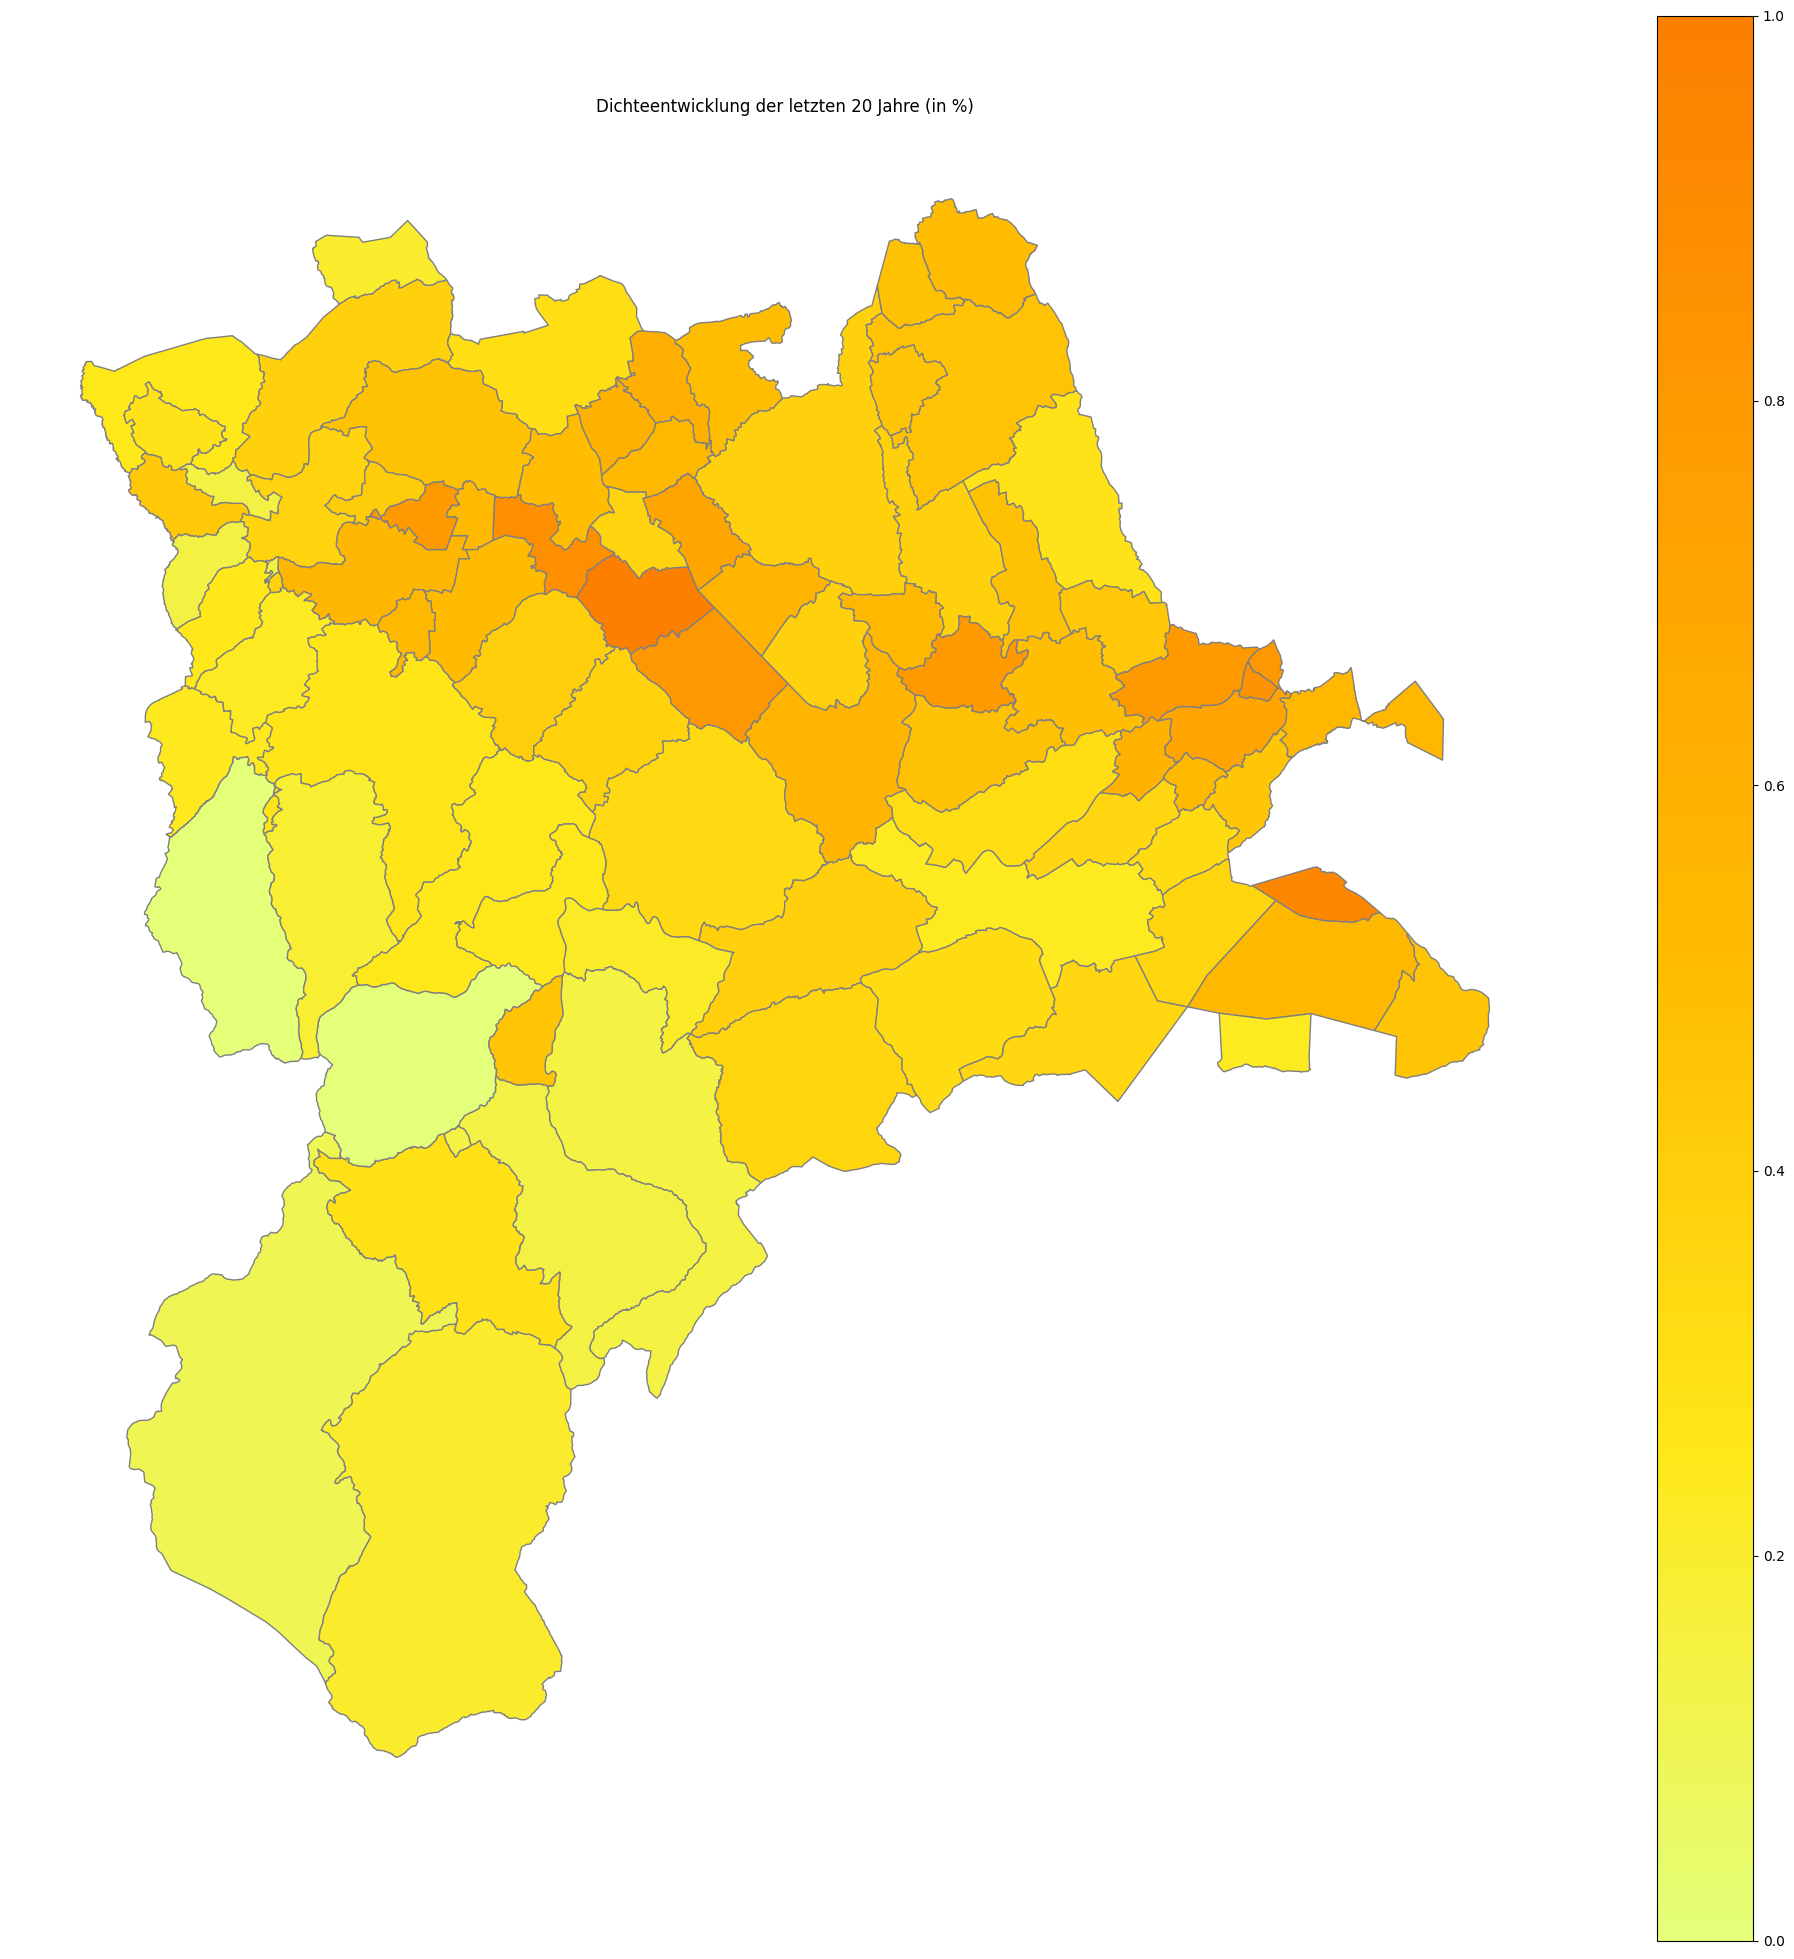

In [31]:
plot_on_lucerne_map(lu_municipalities_shapedata, "Dichteentwicklung der letzten 20 Jahre (in %)", f_size=(25,25))